## Import bibliotek.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

## 1. Wczytanie i przygotowanie zbioru.

In [2]:
wages = pd.read_csv('dane/wages.txt')
wages = wages.query('earn>1100')
wages['height'] = wages['height']*2.54
wages['earn_log10'] = np.log10(wages.earn)
# wages.drop(columns='earn', inplace=True)

## 2. Obsłużenie zmiennych kategorycznych.

In [3]:
wages.dtypes

earn          float64
height        float64
sex            object
race           object
ed              int64
age             int64
earn_log10    float64
dtype: object

In [4]:
wages = pd.get_dummies(wages)

In [5]:
wages.head()

,earn,height,ed,age,earn_log10,sex_female,sex_male,race_black,race_hispanic,race_other,race_white
0,79571.299011,187.6806,16,49,4.900756,0,1,0,0,0,1
1,96396.988643,168.2242,16,62,4.984063,1,0,0,0,0,1
2,48710.666947,161.9758,16,33,4.687624,1,0,0,0,0,1
3,80478.096153,160.5788,16,95,4.905678,1,0,0,0,1,0
4,82089.345498,160.2232,17,43,4.914287,1,0,0,0,0,1


## 3. Podział zbioru.
Zbiór dzielimy w sposób identyczny, jak dla modeli regresji liniowej, celem porównania wyników obu modeli.

In [6]:
wages_tr, wages_te = train_test_split(wages, train_size=0.75, random_state=2001)
wages_tr = wages_tr.copy()
wages_te = wages_te.copy()

## 4. Porównanie z regresją liniową, dla modelu z jedną zmienną objaśniającą.

Porónwanie nastąpi w kontekście sposobu predykcji. Zacznijmy od procesu uczenia.

### 4.1. Uczenie.

In [7]:
model_rl = LinearRegression()
model_rl.fit(wages_tr[['age']], wages_tr[['earn']])

LinearRegression()

In [8]:
model_dd = DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.1)
model_dd.fit(wages_tr[['age']], wages_tr[['earn']])

DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.1)

Zbudujmy 80 obserwacji, w wieku od 20 do 100 lat.

In [9]:
X = np.arange(20, 100, 1).reshape(-1, 1)

In [10]:
X[0:5]

array([[20],
       [21],
       [22],
       [23],
       [24]])

### 4.2. Predykcja.

Wykonajmy teraz predykcję dla obu modeli.

In [11]:
dd_pred = model_dd.predict(X)
rl_pred = model_rl.predict(X).reshape(1, -1)[0]

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<Figure size 720x432 with 0 Axes>

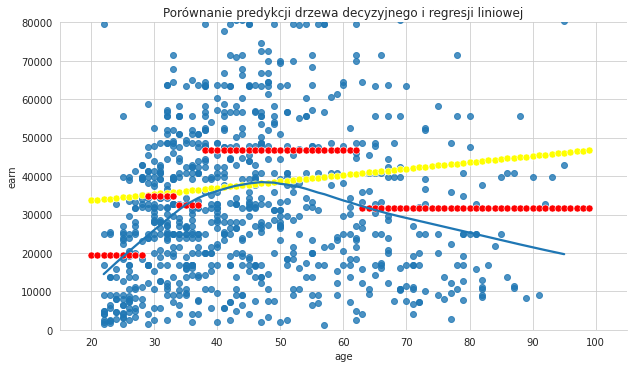

In [12]:
plt.figure(figsize=(10, 6))
sns.lmplot(data=wages_tr, x='age', y='earn', lowess=True, aspect=1.8)
sns.scatterplot(x=X.reshape(1, -1)[0], y=rl_pred, color='yellow', s=50)
sns.scatterplot(x=X.reshape(1, -1)[0], y=dd_pred, color='red', s=50)
plt.title('Porównanie predykcji drzewa decyzyjnego i regresji liniowej')
plt.xlim(15, 105)
plt.ylim(0, 80000)
plt.show()

### 4.3. Porównanie jakości modeli.

In [13]:
pred_tr_rl = model_rl.predict(wages_tr[['age']])
pred_te_rl = model_rl.predict(wages_te[['age']])

pred_tr_dd = model_dd.predict(wages_tr[['age']])
pred_te_dd = model_dd.predict(wages_te[['age']])

score_tr_rl = mean_squared_error(wages_tr.earn, pred_tr_rl, squared=False)
score_te_rl = mean_squared_error(wages_te.earn, pred_te_rl, squared=False)

score_tr_dd = mean_squared_error(wages_tr.earn, pred_tr_dd, squared=False)
score_te_dd = mean_squared_error(wages_te.earn, pred_te_dd, squared=False)

print('Regresja liniowa TR: ', np.round(score_tr_rl, 2))
print('Regresja liniowa TE: ', np.round(score_te_rl, 2))
print('')

print('Drzewo decyzyjne TR: ', np.round(score_tr_dd, 2))
print('Drzewo decyzyjne TE: ', np.round(score_te_dd, 2))

Regresja liniowa TR:  30531.93
Regresja liniowa TE:  31220.7

Drzewo decyzyjne TR:  29167.22
Drzewo decyzyjne TE:  29500.74


### 4.4. Porównanie predykcji.
Spróbujmy wykonać jeszcze kilka predykcji i zobaczmy na czym polega różnica pomiędzy drzewami, a regresją.

**Przykład 1.**
Ocena zarobków osoby w wieku 28 lat.

In [14]:
model_rl.predict([[28]])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[34996.27719611]])

In [15]:
model_dd.predict([[28]])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([19477.53760107])

Spójrzmy teraz na przeciętne zarobki osób, które są w przedziale 26-30.

In [16]:
wages.query('age>=26 & age<=30').earn.median()

24859.9457977036

Oba modele sie dosyć znacząco mylą, choć dla mediany, to drzewa są bliżej prawdy.

**Przykład 2.** Ocena zamożności osoby w wieku 29 lat.

In [17]:
model_rl.predict([[29]])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[35161.77370233]])

In [18]:
35161.77370233-34996.27719611

165.496506219999

W przypadku regresji widzimy subtelny wzrost prognozowanych zarobków o 165 dolarów. Wydaje się to logiczne. Spójrzmy teraz na prognozy drzewa.

In [19]:
model_dd.predict([[29]])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([34933.48696953])

In [20]:
34933.48696953-19477.53760107

15455.949368460002

W przypadku drzewa wzrosły aż o ok. 15.5k dolarów!!! Przyczyną jest fakt, że 29-latki wpadają w zbudowanym drzewie do innego liścia. Przyjrzyjmy się zbudowanemu drzewu, a następnie ponownie rzućmy okiem na wykres z predykcjami.

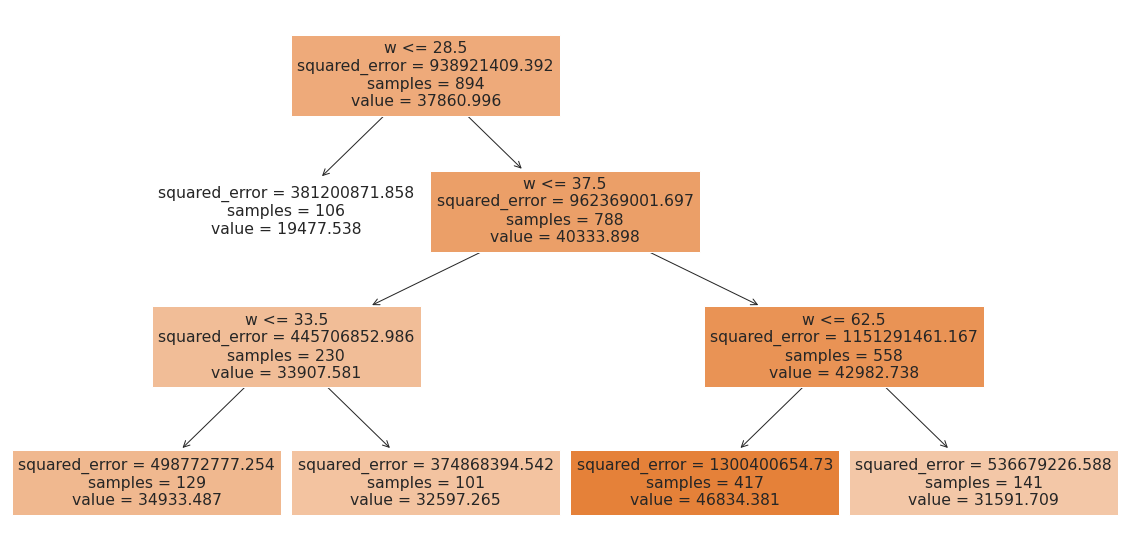

In [21]:
fig = plt.figure(figsize=(20, 10))
_ = tree.plot_tree(model_dd, feature_names='wiek', filled=True)

<Figure size 720x432 with 0 Axes>

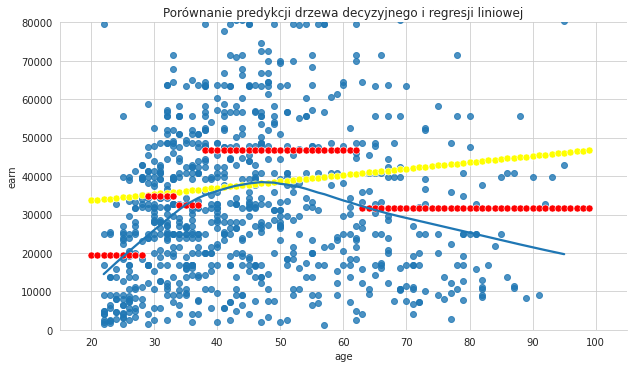

In [22]:
plt.figure(figsize=(10, 6))
sns.lmplot(data=wages_tr, x='age', y='earn', lowess=True, aspect=1.8)
sns.scatterplot(x=X.reshape(1, -1)[0], y=rl_pred, color='yellow', s=50)
sns.scatterplot(x=X.reshape(1, -1)[0], y=dd_pred, color='red', s=50)
plt.title('Porównanie predykcji drzewa decyzyjnego i regresji liniowej')
plt.xlim(15, 105)
plt.ylim(0, 80000)
plt.show()

Wina leży po stronie mechanizmu budującego drzewa. Wykonywane podziały nie są w żaden sposób wygładzane. Mamy widoczne skokowe progi zarobków. Spójrzmy jeszcze na wyniki i porównajmy drzewo z regresją.

Regresja liniowa:
* TR: 30531.93
* TE: 31220.7

Drzewo decyzyjne:
* TR: 29167.22
* TE: 29500.74

Pomimo skokowości w predykcjach drzewo decyzyjne wypada lepiej od regresji. Znacznie lepiej radzi sobie z brakiem monotoniczności we wpływie zmiennej objasniającej na zmienną celu.

Należy w tym miejscu jednak zaznaczyć, że niekiedy takie skokowe predykcje nie są mile widziane.

**Przykład 3**. Zamodelujmy zależność pomiędzy edukacją a zarobkami.

In [23]:
model_rl = LinearRegression()
model_rl.fit(wages_tr[['ed']], wages_tr[['earn']])

LinearRegression()

In [24]:
model_dd = DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.1)
model_dd.fit(wages_tr[['ed']], wages_tr[['earn']])

DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.1)

In [25]:
wages_tr.ed.agg(['min', 'max'])

min     5
max    18
Name: ed, dtype: int64

Zbudujmy 100 obserwacji z poziomem edukacji od 0 do 25 lat (tytuły naukowe dr, profesor, studia podyplomowe, etc.).

In [26]:
X = np.linspace(0, 26, 100).reshape(-1, 1)

In [27]:
X[0:5]

array([[0.        ],
       [0.26262626],
       [0.52525253],
       [0.78787879],
       [1.05050505]])

In [28]:
X.shape

(100, 1)

In [29]:
dd_pred = model_dd.predict(X)
rl_pred = model_rl.predict(X).reshape(1, -1)[0]

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<Figure size 720x432 with 0 Axes>

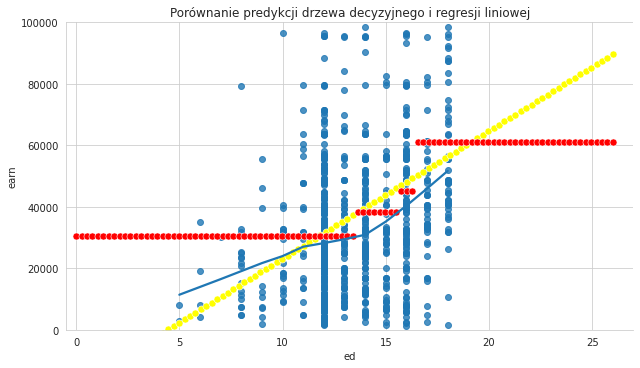

In [30]:
plt.figure(figsize=(10, 6))
sns.lmplot(data=wages_tr, x='ed', y='earn', lowess=True, aspect=1.8)
sns.scatterplot(x=X.reshape(1, -1)[0], y=rl_pred, color='yellow', s=50)
sns.scatterplot(x=X.reshape(1, -1)[0], y=dd_pred, color='red', s=50)
plt.title('Porównanie predykcji drzewa decyzyjnego i regresji liniowej')
plt.xlim(-0.5, 27)
plt.ylim(0, 100000)
plt.show()

W tym przypadku skokowy wzrost poziomu zarobków wraz z kolejnym rokiem nauki może mieć sens - np. fakt ukończenia uczelni wyższej, bądź zdobycia odpowiednigo wykształcenia zawodowego może znacząco wpływać na zarobki. Jest to intuicyjne.

Jeśli progi wyznczone przez drzewo decyzyjne nie pokrywają się z faktycznymi etapami edukacji (szkoła podstawowa, liceum/technikum/szkoła zadowoda, studia, etc.) i z biznesowego punktu widzenia nie jesteśmy w stanie uzasadnić zasadności przyjęcia takich, a nie innych przedziałów, to dobrą praktyką jest **ręczna korekta przedziałów**, już podczas wdrażania modelu.

Spróbujmy wyznaczyć predykcje dla osoby z 18, 20 i 25 latami edukacji.

In [31]:
model_rl.predict([[18]])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[56382.5081081]])

In [32]:
model_rl.predict([[20]])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[64694.87357078]])

In [33]:
model_rl.predict([[25]])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[85475.78722747]])

In [34]:
model_dd.predict([[18]])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([61250.17985126])

In [35]:
model_dd.predict([[20]])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([61250.17985126])

In [36]:
model_dd.predict([[25]])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([61250.17985126])

Widzimy, że od przekroczenia pewnego progu (granicy "najwyższego" liścia) drzewo decyzyjne daje identyczne prognozy. Nie ma różnicy, czy dana osoba uczyła się 18, 25, 30, czy 300 lat. Drzewo deycyzjne zwraca tę samą predykcję.

O ile zgodnie z predykcjami drzewa zarobki rosną wraz ze wzrostem liczby lat edukacji i ogólny trend jest słuszny, to model jednak nie zmienia wartości prognoz dla zakresu zmiennej, którego wcześniej nie widział.

W przypadku poziomu edukacji może to mieć sens (choć ponownie, co z osobami z wykształceniem wyższym i dodatkowymi np. studiami pdyplomowymi?), to są przypadki gdzie sensu to mieć nie będzie.

#### Ryzyko udaru niedokrwiennego
![](zdjęcia/tetnica.png)
Przykład z medycyny i predykcji ryzyka udaru niedokrwiennego: jeśli w zbiorze uczącym mieliśmy samych pacjentów u których maksymalny poziom zweżenia tętnicy szyjnej wynosił 80% (i znacząco podnosiło to ryzyko udaru), to czy dla nowego pacjenta z poziomem zwężenia 90% ryzyko udaru nie powinno być jeszcze wyższe?

**Wnioski**:
* Drzewa **dobrze 4/6** radzą sobie z niemonotonicznymi relacjami (zmiennych ciągłych).
* Drzewa **bardzo dobrze 5/6** radzą sobie z niemonotonicznymi relacjami (zmiennych ciągłych).
* Drzewa **świetnie 6/6** radzą sobie ze zmiennymi kategorycznymi. Sugerowany sposób obsługi zmiennych kategorycznych, to tzw. *dummy coding*/*one hot encoding*.
* Drzewa podobnie, jak regresja liniowa, **wymagają odpowiedniego przygotowania reprezentantywnej, nieobciążonej próby** do modelowania.
* Drzewa gorzej radzą sobie z obsługą wartości ciągłych niż regresja i jej odmiany:
    * Drzewa mają pewne trudności z obsługą "nowych" wartości, których nie zaobserwowały w zbiorze uczących (wartości skrajnie wysokich i niskich).
    * Problem dotyczy zarówno zmiennych objasniających, jak i zmiennej celu.

## 5. Modelowanie.

### 5.0. Baseline.

Baseline - sprawdźmy jak sprawdzi się prognozowanie wartości średniej.

In [37]:
mse_tr = mean_squared_error(wages_tr.earn, np.repeat(wages_tr.earn.mean(), wages_tr.shape[0]), squared=False)
mse_te = mean_squared_error(wages_te.earn, np.repeat(wages_tr.earn.mean(), wages_te.shape[0]), squared=False)
tr_te_diff = mse_te-mse_tr

print('MSE TR: {}'.format(np.round(mse_tr, 2)))
print('MSE TE: {}'.format(np.round(mse_te, 2)))

print('Różnica między wynikiem na zbiorze TR, a TE:', np.round(tr_te_diff, 2))

MSE TR: 30641.82
MSE TE: 31309.21
Różnica między wynikiem na zbiorze TR, a TE: 667.39


### 5.1. Przeuczone drzewo.
Zbudujmy prosty model drzewa decyzyjnego z defaultowymi hiperparametrami.

In [38]:
wages_tr.columns

Index(['earn', 'height', 'ed', 'age', 'earn_log10', 'sex_female', 'sex_male',
       'race_black', 'race_hispanic', 'race_other', 'race_white'],
      dtype='object')

In [39]:
features_to_model = ['height', 'ed', 'age', 'sex_female', 
                     'sex_male', 'race_black', 'race_hispanic',
                     'race_other', 'race_white']
model_1 = DecisionTreeRegressor()
model_1.fit(wages_tr[features_to_model], wages_tr[['earn']])

DecisionTreeRegressor()

In [40]:
pred_tr = model_1.predict(wages_tr[features_to_model])
pred_te = model_1.predict(wages_te[features_to_model])

mse_tr = mean_squared_error(wages_tr.earn, pred_tr, squared=False)
mse_te = mean_squared_error(wages_te.earn, pred_te, squared=False)

tr_te_diff = mse_te-mse_tr

print('MSE TR: {}'.format(np.round(mse_tr, 2)))
print('MSE TE: {}'.format(np.round(mse_te, 2)))
print('Różnica między wynikiem na zbiorze TR, a TE:', np.round(tr_te_diff, 2))

### Wynik osiągnięty przez regresję liniową:
# MSE TR: 26361.12
# MSE TE: 27237.29
# Różnica między TR, a TE: 876.17

MSE TR: 0.0
MSE TE: 40763.45
Różnica między wynikiem na zbiorze TR, a TE: 40763.45


Model na zbiorze uczącym nie popełnia najmniejszego błędu! :-) Na zbiorze testowym wynik jest fatalny.

### 5.2. Niedouczone drzewo.
Zbudujmy prosty model drzewa decyzyjnego z konserwatywnie dobranymi parametrami.

In [41]:
features_to_model = ['height', 'ed', 'age', 'sex_female', 
                     'sex_male', 'race_black', 'race_hispanic',
                     'race_other', 'race_white']
model_2 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.1)
model_2.fit(wages_tr[features_to_model], wages_tr[['earn']])

DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.1)

In [42]:
pred_tr = model_2.predict(wages_tr[features_to_model])
pred_te = model_2.predict(wages_te[features_to_model])

mse_tr = mean_squared_error(wages_tr.earn, pred_tr, squared=False)
mse_te = mean_squared_error(wages_te.earn, pred_te, squared=False)

print('MSE TR: {}'.format(np.round(mse_tr, 2)))
print('MSE TE: {}'.format(np.round(mse_te, 2)))

### Wynik osiągnięty przez regresję liniową:
# MSE TR: 26361.12
# MSE TE: 27237.29
# Różnica między TR, a TE: 876.17

tr_te_diff = mse_te-mse_tr
print('Różnica między wynikiem na zbiorze TR, a TE:', np.round(tr_te_diff, 2))

MSE TR: 26629.96
MSE TE: 28199.7
Różnica między wynikiem na zbiorze TR, a TE: 1569.74


Model teoretycznie jest niedouczony. To, co się rzuca w oczy, to różnica między zbiorem uczącym, a testowym - 1569.74. Prawie dwukrotnie większa niż w przyzpadku regresji liniowej.

### 5.3. Poszukiwanie parametrów drzewa z użyciem GridSearchCV.
Zbudujmy prosty model drzewa decyzyjnego z konserwatywnie dobranymi parametrami.

In [43]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

In [44]:
features_to_model = ['height', 'ed', 'age', 'sex_female', 
                     'sex_male', 'race_black', 'race_hispanic',
                     'race_other', 'race_white']
model_3 = DecisionTreeRegressor()

Przygotujmy siatkę parametrów.

In [45]:
parametry = {
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'min_samples_split': [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3],
    'min_samples_leaf': [1, 5, 10, 15, 20, 30, 40, 50],
    'random_state': [2001]
}

In [46]:
gs = GridSearchCV(model_3, parametry, n_jobs=2, scoring='neg_mean_squared_error', cv=3)

In [47]:
gs

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=2,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 30, 40, 50],
                         'min_samples_split': [0.01, 0.02, 0.05, 0.1, 0.15, 0.2,
                                               0.3],
                         'random_state': [2001]},
             scoring='neg_mean_squared_error')

In [48]:
gs.fit(wages_tr[features_to_model], wages_tr[['earn']])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/tree/_classes.py:397: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=2,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 30, 40, 50],
                         'min_samples_split': [0.01, 0.02, 0.05, 0.1, 0.15, 0.2,
                                               0.3],
                         'random_state': [2001]},
             scoring='neg_mean_squared_error')

In [49]:
gs.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'min_samples_leaf': 15,
 'min_samples_split': 0.01,
 'random_state': 2001}

In [50]:
model_3 = DecisionTreeRegressor(**gs.best_params_)
model_3.fit(wages_tr[features_to_model], wages_tr[['earn']])

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/tree/_classes.py:397: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


DecisionTreeRegressor(criterion='mse', max_depth=5, min_samples_leaf=15,
                      min_samples_split=0.01, random_state=2001)

In [51]:
pred_tr = model_3.predict(wages_tr[features_to_model])
pred_te = model_3.predict(wages_te[features_to_model])

mse_tr = mean_squared_error(wages_tr.earn, pred_tr, squared=False)
mse_te = mean_squared_error(wages_te.earn, pred_te, squared=False)

print('MSE TR: {}'.format(np.round(mse_tr, 2)))
print('MSE TE: {}'.format(np.round(mse_te, 2)))

### Wynik osiągnięty przez regresję liniową:
# MSE TR: 26361.12
# MSE TE: 27237.29
# Różnica między TR, a TE: 876.17

tr_te_diff = mse_te-mse_tr
print('Różnica między wynikiem na zbiorze TR, a TE:', np.round(tr_te_diff, 2))

MSE TR: 24747.29
MSE TE: 26000.0
Różnica między wynikiem na zbiorze TR, a TE: 1252.71


Drzewo decyzyjne posiada dwa "wbudowane" mechanizmy diagnostyczne, które służą podczas interpretacji:
1. **Wizualizacja budowy drzewa** - podziały przedstawione są na acyklicznym grafie skierowanym.
2. **Statystyka *Feature importance*** - podsumowuje kontrybucję poszczególnych zmiennych do osiągniętego przed model rezultatu.

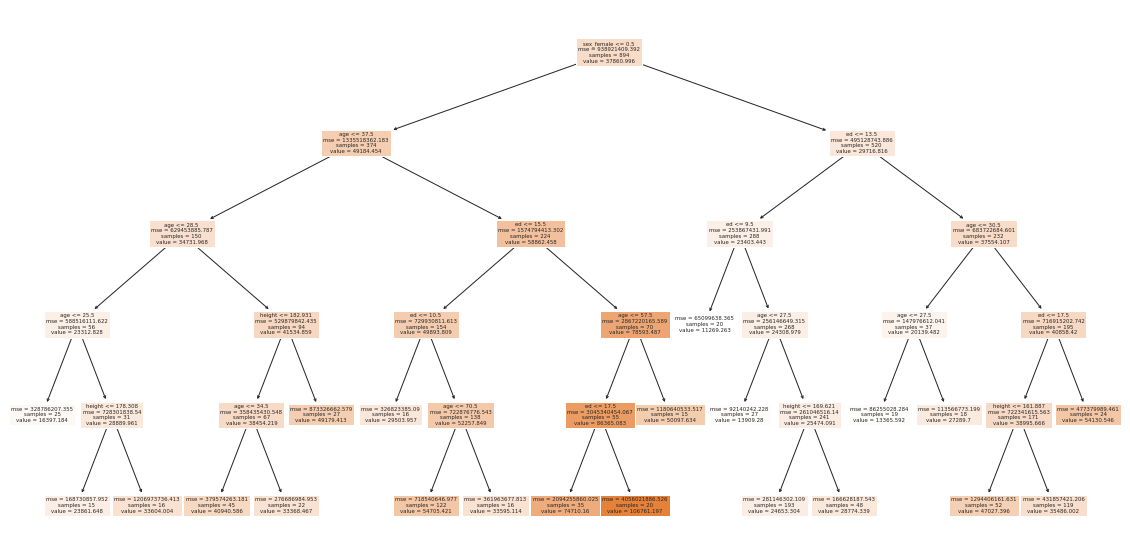

In [52]:
fig = plt.figure(figsize=(20, 10))
_ = tree.plot_tree(model_3, feature_names=features_to_model, filled=True)

Na wizualizacji drzewa doskonale widać, która decyzja wpływa na zmianę predykcji i w jakim kierunku.

***Feature importance*** - jest to statystyka generowana przez drzewo. Mówi ona o tym, jakie zmienne lub cechy mają największy wpływ na podejmowanie decyzji przez to drzewo.

Główne idee związane z obliczaniem feature importance w drzewach decyzyjnych to:

* **Czystość węzłów/liści**: Kiedy drzewo buduje się w procesie uczenia, mierzy się, jak dobrze dane są rozdzielone na podstawie określonej cechy w danym węźle. Czystość jest zwykle mierzona za pomocą funkcji, takich jak Gini lub entropia.
* **Redukcja impurity**: Feature importance mierzy, jak bardzo czystość węzłów ulega zmniejszeniu dzięki podziałom na danej cechy. Wartości feature importance dla danej cechy są obliczane jako suma redukcji impurity we wszystkich węzłach, gdzie ta cecha była użyta do podziału.
* **Waga węzłów**: Waga węzła jest proporcjonalna do liczby próbek, które przechodzą przez dany węzeł. Im więcej danych jest przypisane do węzła, tym bardziej jego cechy mają wpływ na drzewo.

Sprawdźmy *feature importance* dla naszego modelu.

In [53]:
model_3.feature_importances_

array([0.02885252, 0.32153658, 0.36715375, 0.28245714, 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Możemy powyższe nieco lepiej zaprezentować w postaci serii danych.

In [54]:
pd.Series(model_3.feature_importances_, index=features_to_model).sort_values(ascending=False)

age              0.367154
ed               0.321537
sex_female       0.282457
height           0.028853
sex_male         0.000000
race_black       0.000000
race_hispanic    0.000000
race_other       0.000000
race_white       0.000000
dtype: float64

A więc rasa nie jest nawet wzięta pod uwagę przez model. Najistotniejsze są: wiek, edukacja i płeć - wszystkie w podobnym stopniu. Znacznie mniej istotna jest zmienna wskzująca na wzrost danej osoby. Jej wpływ jednak jest marginalny.

Powyższy sposób przedstawiania istotności zmiennych ma swoje plusy i minusy. Minusem jest brak kierunku w jakim wpływa dana zmienna. Nie wiemy na podstawie powyższego, czy edukacja sprawia, że osoby zarabią więcej, czy mniej.

## 6. Inne scenariusze użycia drzewa decyzyjnego.

### 6.1. Feature importance, a selekcja zmiennych

*Feature importance* oprócz czystej diagnostyki modelu, jest również używany do selekcji zmiennych. Drzewo decyzyjne na podstawie reguł automatycznie selekcjonuje istotne zmienne. Statystyka ta jest więc użytecznym narzędziem do selekcji zmiennych do różnych modeli.

Wybieramy spośród wszystkich zmiennych tylko te, które drzewo uznało za istotne. 

UWAGA: Najpierw musimy się upewnić, że drzewo odpowiednio generalizuje na nowych danych. Musimy więc przeprowadzić pełną walidację, by mieć pewność, że wyniki nie są zaburzone.

### 6.2. Użycie drzewa do poszukiwania interakcji pomiędzy zmiennymi.
Na wizualizacji drzewa możemy również odczytać potencjalne interakcje pomiędzy zmiennymi. Kandydatami będą zmienne nstępujące sobie w poszczególnych podziałach. Rzućmy okiem na nasze drzewo.

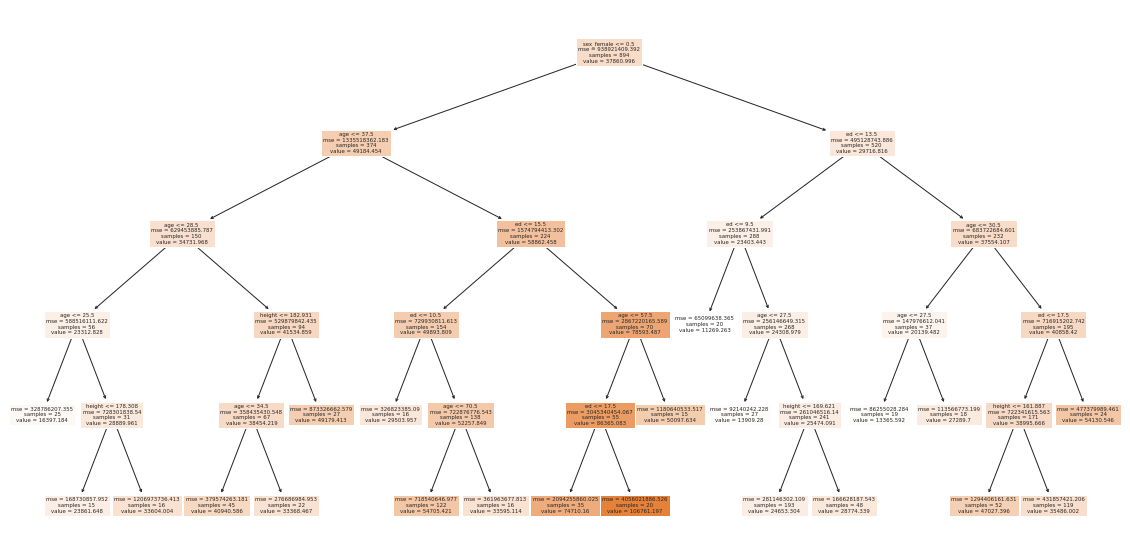

In [55]:
fig = plt.figure(figsize=(20, 10))
_ = tree.plot_tree(model_3, feature_names=features_to_model, filled=True)

Potencjalni kandydaci do uwzględnienia np. w modelu liniowym:
* sex_male vs age
* sex_female vs ed
* ed vs age

### 6.3. Użycie drzewa do dyskretyzacji zmiennej.
Jest to powszechnie stosowany zabieg. Działa zwłaszcza w połączeniu z regresją liniową/logistyczną w przypadku zmiennych niemonotonicznych. Na potrzeby regresji kategoryzujemy zmienne "z nadzorem", a więc uwzględniając zmienną celu. Metody dyskretyzacji "bez nadzoru", np. `pd.cut`, lub `pd.qcut` nie dają aż tak dobrych rezultatów.

Spróbujmy przeprowadzić dyskretyzację zmiennej "age" i sprawdźmy jak ten zabieg wpłynie na moc predykcyjną regresji liniowej.

In [56]:
# najpierw surowa zmienna
model_rl = LinearRegression()
model_rl.fit(wages_tr[['age']], wages_tr[['earn']])

# Drzewo decyzyjne - dla porównania
model_dd = DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.1)
model_dd.fit(wages_tr[['age']], wages_tr[['earn']])

DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.1)

In [57]:
# predykcja i porównanie wyników
pred_tr_rl = model_rl.predict(wages_tr[['age']])
pred_te_rl = model_rl.predict(wages_te[['age']])

pred_tr_dd = model_dd.predict(wages_tr[['age']])
pred_te_dd = model_dd.predict(wages_te[['age']])

score_tr_rl = mean_squared_error(wages_tr.earn, pred_tr_rl, squared=False)
score_te_rl = mean_squared_error(wages_te.earn, pred_te_rl, squared=False)

score_tr_dd = mean_squared_error(wages_tr.earn, pred_tr_dd, squared=False)
score_te_dd = mean_squared_error(wages_te.earn, pred_te_dd, squared=False)

print('Regresja liniowa TR: ', np.round(score_tr_rl, 2))
print('Regresja liniowa TE: ', np.round(score_te_rl, 2))
print('')

print('Drzewo decyzyjne TR: ', np.round(score_tr_dd, 2))
print('Drzewo decyzyjne TE: ', np.round(score_te_dd, 2))

Regresja liniowa TR:  30531.93
Regresja liniowa TE:  31220.7

Drzewo decyzyjne TR:  29167.22
Drzewo decyzyjne TE:  29500.74


Teraz przeprowadźmy dyskretyzację zmiennej.

In [58]:
wages_tr['age_kat'] = model_dd.apply(wages_tr[['age']])
wages_te['age_kat'] = model_dd.apply(wages_te[['age']])

In [59]:
wages_tr.head()

,earn,height,ed,age,earn_log10,sex_female,sex_male,race_black,race_hispanic,race_other,race_white,age_kat
254,20095.545831,167.5638,14,38,4.303100,1,0,1,0,0,0,7
836,24859.796073,166.0144,16,34,4.395498,1,0,0,1,0,0,5
1164,33385.649129,181.9910,15,66,4.523560,0,1,0,1,0,0,8
288,39157.581918,157.4546,14,33,4.592816,1,0,0,0,0,1,4
828,18488.022441,168.1734,10,62,4.266890,1,0,0,0,0,1,7


Teraz zastąpmy "age_kat" średnią wartością "earn" po pogrupowaniu.

In [60]:
slownik = wages_tr.groupby('age_kat').earn.mean().to_dict() # UWAGA: korzystamy tylko ze zbioru uczącego

In [61]:
wages_tr.age_kat.replace(slownik, inplace=True)
wages_te.age_kat.replace(slownik, inplace=True)
wages_tr.head()

,earn,height,ed,age,earn_log10,sex_female,sex_male,race_black,race_hispanic,race_other,race_white,age_kat
254,20095.545831,167.5638,14,38,4.303100,1,0,1,0,0,0,46834.380783
836,24859.796073,166.0144,16,34,4.395498,1,0,0,1,0,0,32597.264895
1164,33385.649129,181.9910,15,66,4.523560,0,1,0,1,0,0,31591.708519
288,39157.581918,157.4546,14,33,4.592816,1,0,0,0,0,1,34933.486970
828,18488.022441,168.1734,10,62,4.266890,1,0,0,0,0,1,46834.380783


In [62]:
# ponowne modelowanie, tym razem z uzyciem zmiennej po kategoryzacji
model_rl = LinearRegression()
model_rl.fit(wages_tr[['age_kat']], wages_tr[['earn']])

pred_tr_rl = model_rl.predict(wages_tr[['age_kat']])
pred_te_rl = model_rl.predict(wages_te[['age_kat']])

score_tr_rl = mean_squared_error(wages_tr.earn, pred_tr_rl, squared=False)
score_te_rl = mean_squared_error(wages_te.earn, pred_te_rl, squared=False)

print('Regresja liniowa TR: ', np.round(score_tr_rl, 2))
print('Regresja liniowa TE: ', np.round(score_te_rl, 2))

Regresja liniowa TR:  29167.22
Regresja liniowa TE:  29500.74


Znacząco poprawiliśmy wynik regresji liniowej.
* TR:  30531.93 &rarr; 29167.22
* TE:  31220.7 &rarr; 29500.74 

Źródła:
* Zdjęcie tętnic szyjnych: https://pl.wikipedia.org/wiki/Zw%C4%99%C5%BCenie_t%C4%99tnic_szyjnych#/media/Plik:Carotid_artery_stenosis.png